In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
train = pd.read_csv('../Data/train.csv')

train = train.drop("id", axis = 1)

defect_counts = train[["Pastry","Z_Scratch","K_Scatch","Stains","Dirtiness","Bumps","Other_Faults"]].sum(axis=1)
train = train[defect_counts==1]

train['target'] = train[["Pastry","Z_Scratch","K_Scatch","Stains","Dirtiness","Bumps","Other_Faults"]].apply(lambda row: row.idxmax(), axis=1)
train = train.drop(["Pastry","Z_Scratch","K_Scatch","Stains","Dirtiness","Bumps","Other_Faults"],axis = 1)

label_map = {'Pastry': 0, 'Z_Scratch': 1, 'K_Scatch': 2, 'Stains': 3, 'Dirtiness': 4, 'Bumps': 5, 'Other_Faults': 6}
train['target'] = train['target'].map(label_map)

In [3]:
train['_Aspect_Ratio'] = (train['X_Maximum'] - train['X_Minimum']) / (abs(train['Y_Maximum'] - train['Y_Minimum']) + 1)
train['_Area_Perimeter_Ratio_X'] = train['Pixels_Areas'] / train['X_Perimeter']
train['_Area_Perimeter_Ratio_Y'] = train['Pixels_Areas'] / train['Y_Perimeter']
train['_Compactness_X'] = train['Pixels_Areas'] / (train['X_Perimeter'] ** 2)
train['_Compactness_Y'] = train['Pixels_Areas'] / (train['Y_Perimeter'] ** 2)
train['_Color_Range'] = train['Maximum_of_Luminosity'] - train['Minimum_of_Luminosity']
train['_Spatial_Distribution_Index'] = train['Edges_Index'] + train['Empty_Index'] + train['Square_Index'] + train['Outside_X_Index'] + train['Edges_X_Index'] + train['Edges_Y_Index'] + train['Outside_Global_Index']
train['_Log_Area_Perimeter_Ratio'] = train['LogOfAreas'] / (train['Log_X_Index'] + train['Log_Y_Index'])
train['_Normalized_Luminosity_Index'] = train['Luminosity_Index'] / train['Pixels_Areas']
train['_Thickness_Steel_Type'] = train['Steel_Plate_Thickness'] * (train['TypeOfSteel_A300'] + train['TypeOfSteel_A400'])
train['_Edge_to_Area_Ratio'] = train['Edges_Index'] / train['Pixels_Areas']


In [4]:
train['TypeOfSteel'] = train.apply(lambda row: 0 if row['TypeOfSteel_A300'] == 1 else (1 if row['TypeOfSteel_A400'] == 1 else None), axis=1)
train = train.drop(["TypeOfSteel_A300", "TypeOfSteel_A400"], axis = 1)
train.dropna(inplace=True)

In [5]:
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_classification

X = train.drop("target", axis = 1)
y = train["target"]

model = XGBClassifier(
    objective='multi:softmax',
    grow_policy = 'depthwise',
    n_estimators = 841,
    learning_rate = 0.020842266188372684,
    gamma = 0.3161972960843992,
    subsample = 0.8717065504925866,
    colsample_bytree = 0.31637748067432303,
    max_depth = 3,
    min_child_weight = 6,
    reg_lambda = 5.675430918203272e-09,
    reg_alpha = 3.0943705922938466e-09,


)

model.fit(X, y)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.31637748067432303, device=None,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=0.3161972960843992,
              grow_policy='depthwise', importance_type=None,
              interaction_constraints=None, learning_rate=0.020842266188372684,
              max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=6, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=841, n_jobs=None,
              num_parallel_tree=None, objective='multi:softmax', ...)

In [6]:
y_score = model.predict_proba(X)
y_pred = model.predict(X)

In [7]:
from sklearn.metrics import roc_auc_score

micro_roc_auc_ovr = roc_auc_score(
    y,
    y_score,
    multi_class="ovr",
    average="macro",
)
micro_roc_auc_ovr

0.9201433618328748

In [8]:
from sklearn.metrics import f1_score

f1 = f1_score(
    y,
    y_pred,
    average='macro'  
)
f1

0.6176708245556577

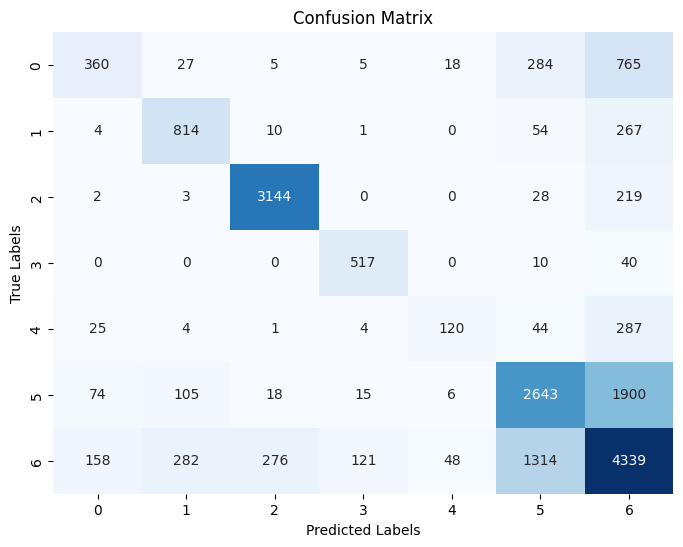

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

y_pred = model.predict(X)

conf_matrix = confusion_matrix(y, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, cmap="Blues", fmt="d", cbar=False)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

In [93]:
import shap
explainer = shap.Explainer(model)
shap_values = explainer.shap_values(X)

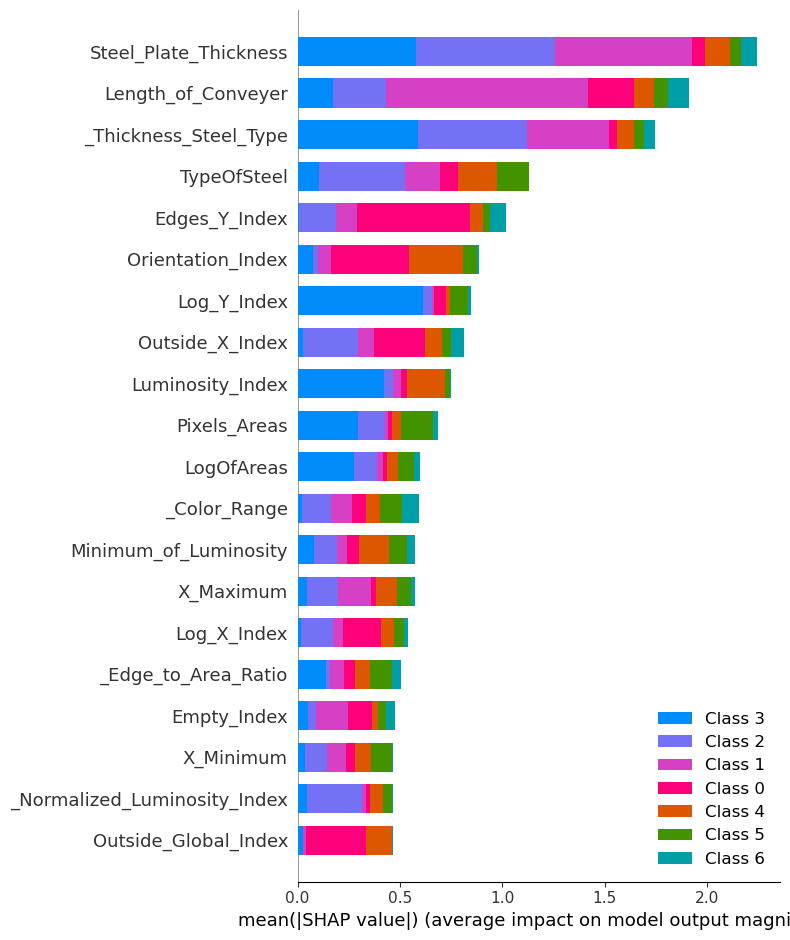

In [94]:
shap.summary_plot(shap_values, X)

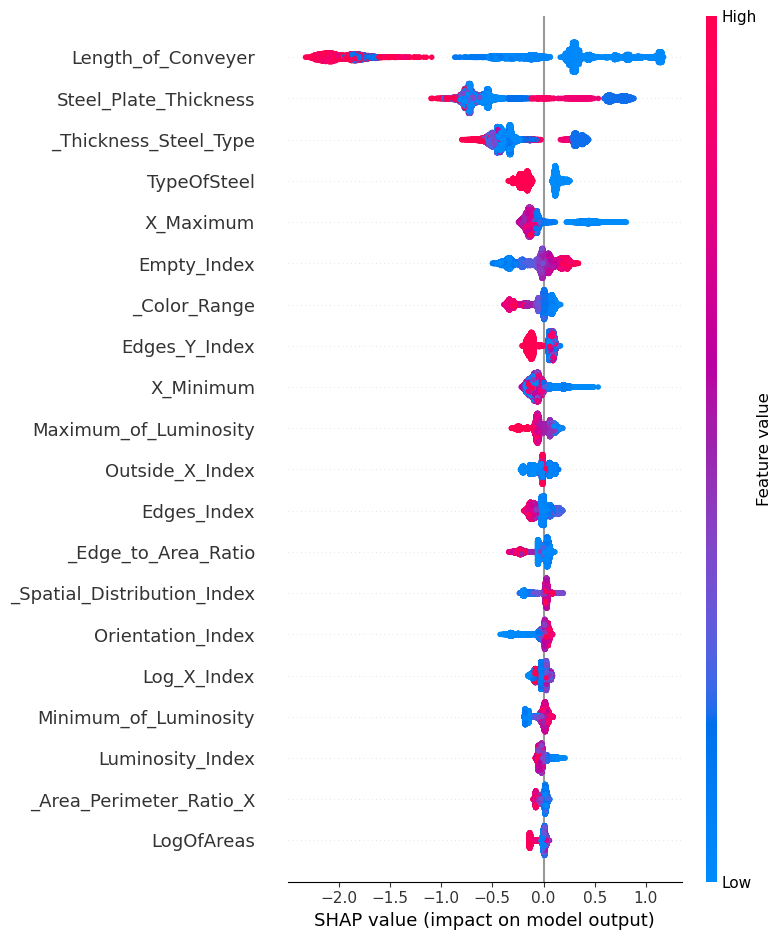

In [95]:
shap.summary_plot(shap_values[1], X)

## Erro Analysis

In [201]:
erTrainX = X.reset_index(drop=True)
erTrainy = y.reset_index(drop=True)

In [207]:
predicted_train = erTrainX
predicted_train["target"] = erTrainy
predicted_train["pred_target"] = y_pred

In [215]:
l35 = predicted_train.query('target == 3 & (pred_target == 5)')
l35Id = l35.index

In [216]:
trainPred = pd.DataFrame(y_score, index = predicted_train.index)
trainPred.columns = ["Pastry","Z_Scratch","K_Scatch","Stains","Dirtiness","Bumps","Other_Faults"]

In [219]:
predicted_train.iloc[l35Id]

,X_Minimum,X_Maximum,Y_Minimum,Y_Maximum,Pixels_Areas,X_Perimeter,Y_Perimeter,Sum_of_Luminosity,Minimum_of_Luminosity,Maximum_of_Luminosity,...,_Compactness_Y,_Color_Range,_Spatial_Distribution_Index,_Log_Area_Perimeter_Ratio,_Normalized_Luminosity_Index,_Thickness_Steel_Type,_Edge_to_Area_Ratio,TypeOfSteel,target,pred_target
1295,419,424,126951,126958,66,8,12,7394,89,126,...,0.458333,37,4.5583,0.894807,-0.002126,50,0.009595,1.0,3,5
6586,974,992,5897947,5897955,63,51,10,6165,111,132,...,0.630000,21,3.9082,0.727666,-0.000954,40,0.014546,0.0,3,5
8052,858,868,12987661,12987692,56,13,15,6116,92,127,...,0.248889,35,4.2473,0.803364,-0.002282,50,0.016484,1.0,3,5
10395,893,917,733668,733675,212,37,35,25563,95,141,...,0.173061,46,3.1829,0.860424,-0.000257,40,0.003741,1.0,3,5
11730,929,941,1823987,1824016,116,20,15,14471,115,142,...,0.515556,27,4.2597,0.948716,0.000014,60,0.005979,1.0,3,5
13915,508,518,294032,294036,64,10,10,7659,108,140,...,0.640000,32,4.4995,0.978917,-0.000769,50,0.009598,1.0,3,5
14207,623,631,1413654,1413720,51,9,8,6684,102,132,...,0.796875,30,3.9568,0.945410,-0.001900,100,0.018100,1.0,3,5
16680,797,804,1587172,1587191,12,11,10,1587,102,132,...,0.120000,30,4.4925,0.539600,-0.007242,60,0.056458,0.0,3,5
17931,385,399,289529,289543,54,17,12,7145,104,126,...,0.375000,22,3.0292,0.824835,-0.001800,50,0.010539,1.0,3,5
18074,1199,1201,1133715,1133734,40,8,10,4557,80,140,...,0.400000,60,4.4141,0.868300,-0.003110,50,0.008345,1.0,3,5


## Weight idea

In [123]:
trainPred = pd.DataFrame(y_score)
trainPred.columns = ["Pastry","Z_Scratch","K_Scatch","Stains","Dirtiness","Bumps","Other_Faults"]
trainPred

,Pastry,Z_Scratch,K_Scatch,Stains,Dirtiness,Bumps,Other_Faults
0,0.002647,0.000921,0.001085,0.868965,0.003562,0.012773,0.110047
1,0.440038,0.000840,0.000535,0.000125,0.006000,0.219314,0.333147
2,0.000348,0.000426,0.937604,0.000060,0.000302,0.001173,0.060086
3,0.130527,0.005984,0.073840,0.001553,0.107026,0.141262,0.539809
4,0.154673,0.002923,0.003491,0.000066,0.015205,0.056359,0.767283
...,...,...,...,...,...,...,...
18356,0.180133,0.010605,0.065627,0.000078,0.011330,0.017365,0.714862
18357,0.070074,0.009866,0.000947,0.000324,0.028519,0.318444,0.571826
18358,0.176170,0.048313,0.028833,0.000181,0.026487,0.121026,0.598990
18359,0.427978,0.004506,0.000590,0.000679,0.033800,0.208236,0.324212


In [124]:
train['target'].value_counts()

weights = [1464, 1150, 3396, 567, 485, 4761, 6538]
result = [(18361 - value) / 18361 for value in weights]
result


[0.920265780730897,
 0.9373672457927128,
 0.8150427536626546,
 0.969119329012581,
 0.9735853167038833,
 0.740700397581831,
 0.6439191765154403]

In [130]:
tafmul = trainPred*result
tafmul

,Pastry,Z_Scratch,K_Scatch,Stains,Dirtiness,Bumps,Other_Faults
0,0.002436,0.000864,0.000885,0.842131,0.003468,0.009461,0.070861
1,0.404952,0.000788,0.000436,0.000121,0.005842,0.162446,0.214520
2,0.000320,0.000399,0.764188,0.000058,0.000294,0.000869,0.038691
3,0.120119,0.005609,0.060182,0.001505,0.104199,0.104633,0.347593
4,0.142340,0.002740,0.002845,0.000064,0.014804,0.041745,0.494068
...,...,...,...,...,...,...,...
18356,0.165771,0.009941,0.053488,0.000075,0.011031,0.012863,0.460313
18357,0.064487,0.009248,0.000771,0.000314,0.027765,0.235871,0.368210
18358,0.162123,0.045287,0.023500,0.000175,0.025787,0.089644,0.385701
18359,0.393853,0.004223,0.000480,0.000658,0.032907,0.154240,0.208766


In [136]:
weightPred = tafmul.div(tafmul.sum(axis=1), axis=0)
weightPred

,Pastry,Z_Scratch,K_Scatch,Stains,Dirtiness,Bumps,Other_Faults
0,0.002619,0.000929,0.000951,0.905415,0.003729,0.010172,0.076186
1,0.513179,0.000998,0.000553,0.000154,0.007403,0.205861,0.271852
2,0.000398,0.000496,0.949515,0.000072,0.000366,0.001080,0.048074
3,0.161485,0.007541,0.080908,0.002024,0.140082,0.140666,0.467295
4,0.203748,0.003922,0.004073,0.000091,0.021190,0.059755,0.707220
...,...,...,...,...,...,...,...
18356,0.232340,0.013933,0.074968,0.000106,0.015460,0.018028,0.645165
18357,0.091255,0.013087,0.001092,0.000444,0.039291,0.333780,0.521051
18358,0.221414,0.061849,0.032095,0.000239,0.035218,0.122428,0.526757
18359,0.495332,0.005312,0.000604,0.000828,0.041386,0.193981,0.262557


In [144]:
max_column_indices = [weightPred.iloc[i].idxmax() for i in range(len(weightPred))]
max_column_indices

string_list = ["Pastry", "Z_Scratch", "K_Scatch", "Stains", "Dirtiness", "Bumps", "Other_Faults"]


mapping = {"Pastry": 0, "Z_Scratch": 1, "K_Scatch": 2, "Stains": 3, "Dirtiness": 4, "Bumps": 5, "Other_Faults":6}

numeric_list = [mapping[s] for s in max_column_indices]
numeric_list

weightPred = np.array(numeric_list)
weightPred

array([3, 0, 2, ..., 6, 0, 5])

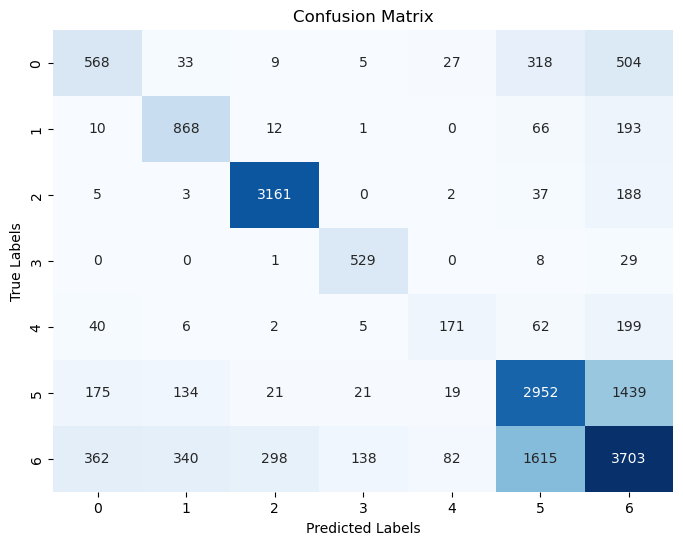

In [145]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

conf_matrix = confusion_matrix(y, weightPred)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, cmap="Blues", fmt="d", cbar=False)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

In [ ]:
## Not that much important